In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plot
import math
from matplotlib import rc
from pylab import rcParams

import pandas as pd
import numpy as numpy
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='jpeg'
# !jupyter nbextension enable --py widgetsnbextension

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
tqdm.pandas()
pl.seed_everything(42)

Seed set to 42


42

### Import dataset

In [3]:
df = pd.read_csv('../datasets/household_power_consumption_v3_drop.txt', parse_dates={'datetime' : ['date','time']}, index_col='datetime', sep=';', usecols=[1,2,3,4,5,6,7,8,9,11,12,13])
df.head(5)

,global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year
datetime,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006


In [4]:
cols = ['global_reactive_power', 'voltage', 'global_intensity', 'kitchen', 'laundry_room', 'thermal_utilities', 'day', 'month', 'year', 'global_active_power']
features_df = df[cols]
features_df.head()

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006,4.216
2006-12-16 17:25:00,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006,5.360
2006-12-16 17:26:00,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006,5.374
2006-12-16 17:27:00,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006,5.388
2006-12-16 17:28:00,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006,3.666


### Preprocessing 

Split - Train ```.6```, Validation ```.2```, Test ```.2```

In [5]:
train_size = int(len(features_df) * .6) # 60% training
val_size = int((len(features_df) - train_size) * .5) + train_size # 20% validation and test
train_size, val_size

(1229568, 1639424)

In [6]:
train_df, val_df, test_df = features_df[:train_size], features_df[train_size:val_size], features_df[val_size:]
print(train_df.shape, val_df.shape, test_df.shape)

(1229568, 10) (409856, 10) (409856, 10)


__Normalization__

In [7]:
# scalling data only using train df
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [8]:
train_df = pd.DataFrame(
    scaler.transform(train_df), 
    index=train_df.index, 
    columns=train_df.columns)
train_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,-0.398561,-0.254516,-0.244813,-1.0,-0.974359,0.096774,0.0,1.0,-1.0,-0.250407
2006-12-16 17:25:00,-0.372662,-0.333990,-0.053942,-1.0,-0.974359,0.032258,0.0,1.0,-1.0,-0.043274
2006-12-16 17:26:00,-0.283453,-0.356322,-0.053942,-1.0,-0.948718,0.096774,0.0,1.0,-1.0,-0.040739


In [9]:
test_df = pd.DataFrame(
    scaler.transform(test_df), 
    index=test_df.index, 
    columns=test_df.columns)
test_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2010-02-05 04:29:00,-0.516547,0.559278,-0.900415,-1.0,-0.948718,-0.935484,-0.733333,-0.818182,1.666667,-0.915263
2010-02-05 04:30:00,-0.522302,0.552053,-0.900415,-1.0,-0.974359,-0.935484,-0.733333,-0.818182,1.666667,-0.918160
2010-02-05 04:31:00,-0.516547,0.598686,-0.900415,-1.0,-0.974359,-1.000000,-0.733333,-0.818182,1.666667,-0.918160


In [10]:
val_df = pd.DataFrame(
    scaler.transform(val_df), 
    index=val_df.index, 
    columns=val_df.columns)
val_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2009-04-21 11:11:00,-0.458993,-0.120525,-0.659751,-1.0,-1.0,0.16129,0.333333,-0.454545,1.0,-0.677711
2009-04-21 11:12:00,-0.159712,-0.129064,-0.618257,-1.0,-1.0,0.16129,0.333333,-0.454545,1.0,-0.628825
2009-04-21 11:13:00,-0.165468,-0.201314,-0.618257,-1.0,-1.0,0.16129,0.333333,-0.454545,1.0,-0.637154


__Create sequence__

In [11]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, offset = 1):
    sequences = []
    data_size = len(input_data)
    
    for i in range(data_size - sequence_length):
        sequence = input_data[i:i+sequence_length]
        
        label_poisition = i+sequence_length
        label = input_data.iloc[label_poisition:label_poisition+offset][target_column]
        
        sequences.append((sequence, label))
        
    return sequences

In [12]:
num_seq = 60 # 60 minutes
offset = 1
train_sequences = create_sequences(train_df, 'global_active_power', num_seq, offset)
val_sequences = create_sequences(val_df, 'global_active_power', num_seq, offset)
test_sequences = create_sequences(test_df, 'global_active_power', num_seq, offset)

In [13]:
len(train_sequences), len(val_sequences), len(test_sequences)

(1229508, 409796, 409796)

### Create dataset

In [14]:
class PCDataset(Dataset):
    def __init__(self, sequences):
        # super().__init__()
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        sequence, label = self.sequences[index]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device='cuda') if torch.cuda.is_available() else torch.Tensor(sequence.to_numpy()), # put to cuda device if available
            label = torch.Tensor(label).float().to(device='cuda') if torch.cuda.is_available() else torch.Tensor(label).float() # put to cuda device if available
        )
        

Pytorch lightning data module

In [15]:
class PCDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        print('batch size', self.batch_size)
        
    def setup(self, stage=None):
        self.train_dataset = PCDataset(self.train_sequences)
        self.val_dataset = PCDataset(self.val_sequences)
        self.test_dataset = PCDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )
        
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )

Setup data module

In [16]:
num_epoch = 5
batch_size = 64

data_module = PCDataModule(train_sequences, test_sequences, batch_size)
data_module.setup()

batch size 64


### Model building

Pytorch model

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, n_features, n_hidden=64, kernel_size=2, lstm_input_size=None):
        super(CNNLSTM, self).__init__()
        self.n_hidden = n_hidden
        
        ### CNN
        # convolution layer
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=n_hidden, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=kernel_size)
        
        # pooling layer
        self.pool1 = nn.MaxPool1d(kernel_size=kernel_size, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=kernel_size, stride=2)
        
        
        ### LSTM 
        if lstm_input_size is not None:
            self.lstm = nn.LSTM(
                input_size=lstm_input_size,
                hidden_size=n_hidden,
                batch_first=True,
                num_layers=1,
                dropout=0.2
            )
        else:
            self.lstm = None
        # self.lstm = None
        
        # linear
        self.lin1 = nn.Linear(self.n_hidden, 32)
        self.lin2 = nn.Linear(32, 1)
        
        self.initialized = False
    
    def forward(self, x):
        
        # print("shape", x.shape)
        x = x.transpose(1,2)
        # conv1
        x = self.conv1(x)
        x = x.relu()
        x = self.pool1(x)
        
        # conv2
        x = self.conv2(x)
        x = x.relu()
        x = self.pool2(x)
        
        # flatten
        print("size x", x.size())
        x = torch.flatten(x, start_dim=1)
        
        # Dynamically create lstm + linear layers if not already created
        if not self.initialized:
            n_size = x.size(1)
            print("size", n_size)
            self.lstm = nn.LSTM(
                input_size=n_size, #input feature
                hidden_size=self.n_hidden,
                batch_first=True,
                num_layers=1,
                dropout=0.2
            ).to(x.device)
            
            # self.lin1 = nn.Linear(self.n_hidden, 32).to(x.device)
            # self.lin2 = nn.Linear(32, 1).to(x.device)
            self.initialized = True
        
        # LSTM
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x) # take the hidden state
        x = hidden[-1] # take the last layer, which contains the features
        
        # Linear layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        
        return x

Pytorch lightning predictor wrapper

In [18]:
from typing import Any
class PCPredictor(pl.LightningModule):
    def __init__(self, n_features: int, model = CNNLSTM, lstm_input_size=None):
        super().__init__()
        if lstm_input_size:
            self.model = model(n_features=n_features, lstm_input_size=lstm_input_size)
        else:
            self.model = model(n_features)
        self.criterion = nn.MSELoss() #loss function
    
    def forward(self,x,labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):# -> OptimizerLRScheduler:
        return optim.Adam(self.parameters(), lr=0.0001)

In [19]:
model = PCPredictor(train_df.shape[1])

In [20]:
%reload_ext tensorboard

%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 10996), started 1 day, 1:54:11 ago. (Use '!kill 10996' to kill it.)

In [21]:
checkpoint_callback = ModelCheckpoint(
    dirpath='../checkpoints',
    filename='best-checkpoint-cnnlstm',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='pc')

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

trainer = pl.Trainer(
    logger=logger,
    # checkpoint_callback=checkpoint_callback,
    callbacks=[checkpoint_callback],
    max_epochs=num_epoch,
    accelerator="gpu",
    devices=1,
    # progress_bar_refresh_rate=30,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | CNNLSTM | 257 K 
1 | criterion | MSELoss | 0     
--------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.032     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

# Model testing

Load model

In [237]:
# later: how to find this
checkpoint = torch.load('../checkpoints/best-checkpoint-cnnlstm.ckpt')
lstm_input_size=checkpoint['state_dict']['model.lstm.weight_ih_l0'].size()[1]
for param_name, weigth in checkpoint['state_dict'].items():
    print(param_name)
    
# print(checkpoint['state_dict']['model.lstm.weight_ih_l0'].size()[1])

# Update the keys by removing the 'model.' prefix
updated_state_dict = {key.replace('model.', ''): value for key, value in checkpoint['state_dict'].items()}

# Now load the updated state_dict into your model
best_model = CNNLSTM(n_features=train_df.shape[1], lstm_input_size=lstm_input_size)  # Initialize your model as before
best_model.load_state_dict(updated_state_dict)


model.conv1.weight
model.conv1.bias
model.conv2.weight
model.conv2.bias
model.lin1.weight
model.lin1.bias
model.lin2.weight
model.lin2.bias
model.lstm.weight_ih_l0
model.lstm.weight_hh_l0
model.lstm.bias_ih_l0
model.lstm.bias_hh_l0


<All keys matched successfully>

In [213]:
## new initiated model
# ([-0.0953255146741867, -0.09527189284563065],
#  [-0.8551511764526367, -0.857323944568634])

## trained model
# ([-0.43711525201797485, -0.43707114458084106],
#  [-0.8551511764526367, -0.857323944568634])

## trained saved model
# ([0.05117300525307655, 0.051082007586956024],
#  [-0.8551511764526367, -0.857323944568634])

Test dataset

In [238]:
test_dataset = PCDataset(test_sequences)

predictions = []
labels = []
best_model.to(torch.device('cuda'))
step = 0
maxstep = -1
for item in test_dataset:
    if step == maxstep:
        break
    step+=1
    # print(step)
    
    sequence = item['sequence']
    label = item['label']
    
    output = best_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())
predictions[0], labels[0]

size 896


(0.11610191315412521, -0.8551511764526367)

In [239]:
result_df = pd.DataFrame(
    {
        'predictions': predictions,
        'labels': labels
    }
)

In [241]:
from torchmetrics.regression import MeanSquaredError
mse = MeanSquaredError()
mse_result_test = mse(torch.tensor(result_df['predictions'].values), torch.tensor(result_df['labels'].values))
mse_result_test

tensor(0.9371)

<Axes: >

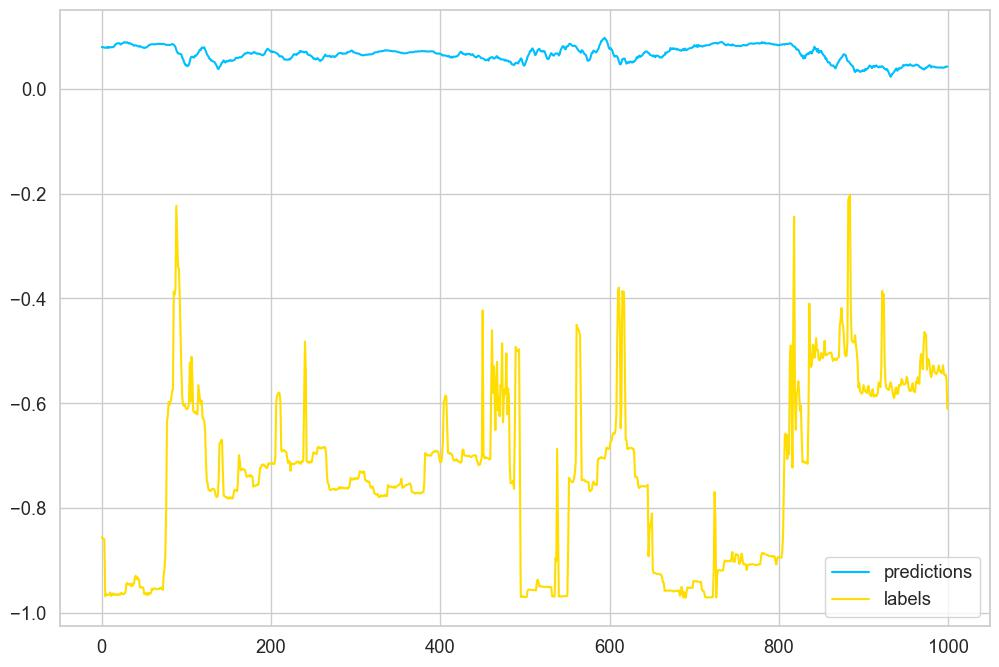

In [232]:
result_df[:1000].plot()

Val dataset

In [243]:
val_dataset = PCDataset(val_sequences)

predictions_2 = []
labels_2 = []
best_model.to(torch.device('cuda'))

for item in val_dataset:
    sequence = item['sequence']
    label = item['label']
    
    output = best_model(sequence.unsqueeze(dim=0))
    predictions_2.append(output.item())
    labels_2.append(label.item())

In [244]:
result_test_df = pd.DataFrame(
    {
        'predictions': predictions_2,
        'labels': labels_2
    }
)

In [245]:
from torchmetrics.regression import MeanSquaredError
mse = MeanSquaredError()
mse_result_test = mse(torch.tensor(result_test_df['predictions'].values), torch.tensor(result_test_df['labels'].values))
mse_result_test

tensor(0.9215)

<Axes: >

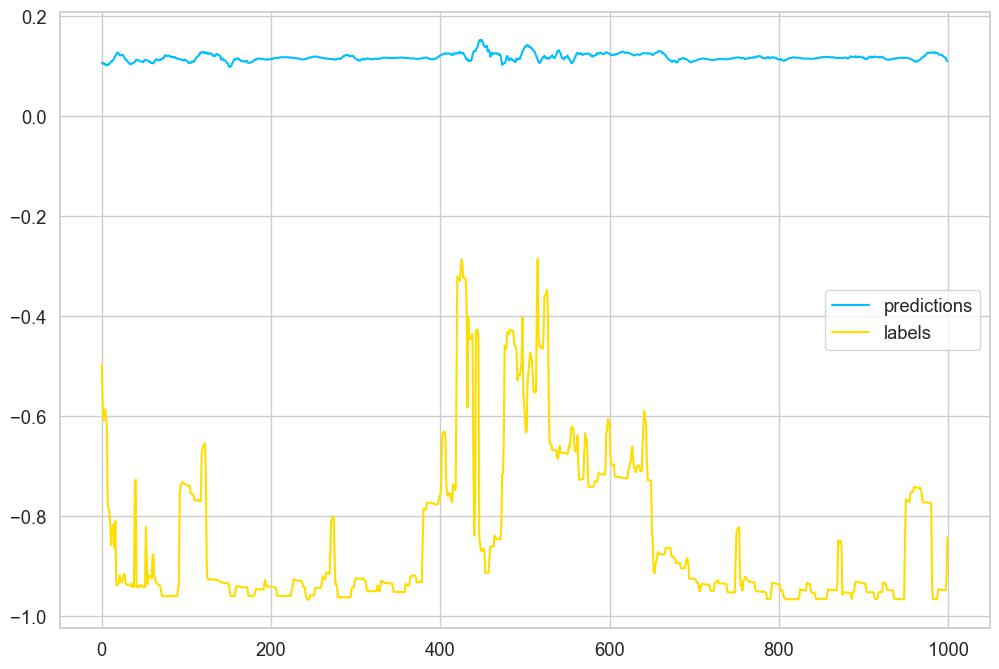

In [246]:
result_test_df[:1000].plot()

## OLD

Test dataset

In [ ]:
test_dataset = PCDataset(test_sequences)

predictions = []
labels = []
model2.to(torch.device('cuda'))

for item in test_dataset:
    sequence = item['sequence']
    label = item['label']
    
    _, output = model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

In [86]:
result_df = pd.DataFrame(
    {
        'predictions': predictions,
        'labels': labels
    }
)

<Axes: >

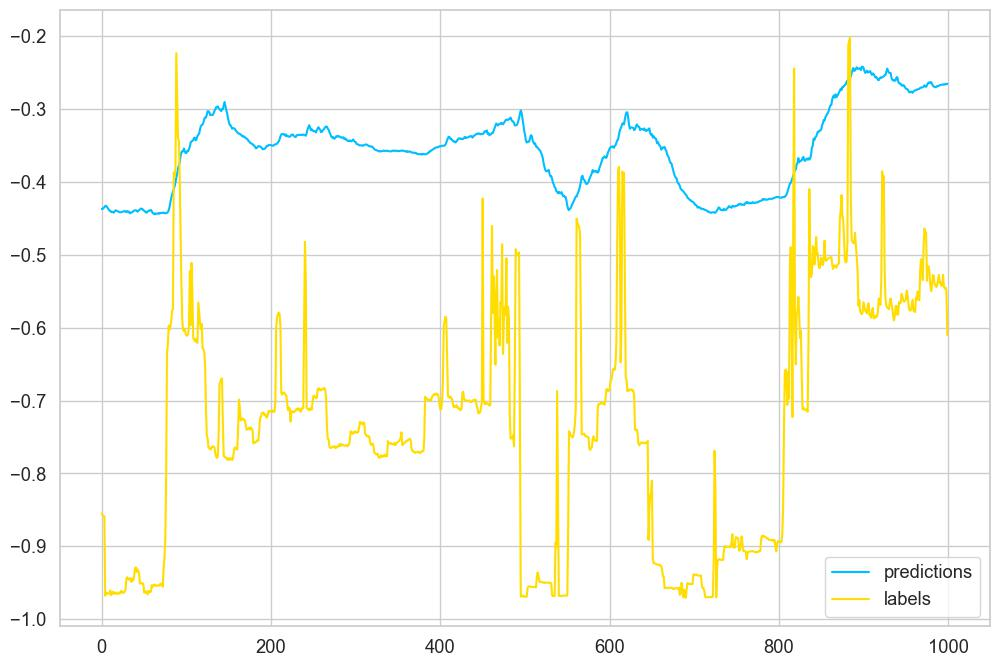

In [89]:
result_df[:1000].plot()

In [91]:
from torchmetrics.regression import MeanSquaredError
mse = MeanSquaredError()
mse_result = mse(torch.tensor(result_df['predictions'].values), torch.tensor(result_df['labels'].values))
torch.tensor(result_df['predictions'].values)

tensor([-0.4371, -0.4371, -0.4358,  ..., -0.3897, -0.3908, -0.3910],
       dtype=torch.float64)

In [92]:
mse_result

tensor(0.2110)

In [94]:
for name, p in model.named_parameters():
    print(name)

model.conv1.weight
model.conv1.bias
model.conv2.weight
model.conv2.bias
model.lin1.weight
model.lin1.bias
model.lin2.weight
model.lin2.bias
model.lstm.weight_ih_l0
model.lstm.weight_hh_l0
model.lstm.bias_ih_l0
model.lstm.bias_hh_l0


Val dataset

In [95]:
val_dataset = PCDataset(val_sequences)

predictions_2 = []
labels_2 = []
model.to(torch.device('cuda'))

for item in val_dataset:
    
    # print(item['sequence'])
    # break
    sequence = item['sequence']
    label = item['label']
    
    _, output = model(sequence.unsqueeze(dim=0))
    predictions_2.append(output.item())
    labels_2.append(label.item())

In [96]:
result_test_df = pd.DataFrame(
    {
        'predictions': predictions_2,
        'labels': labels_2
    }
)

In [100]:
from torchmetrics.regression import MeanSquaredError
mse = MeanSquaredError()
mse_result_test = mse(torch.tensor(result_test_df['predictions'].values), torch.tensor(result_test_df['labels'].values))
mse_result_test

tensor(0.2002)

<Axes: >

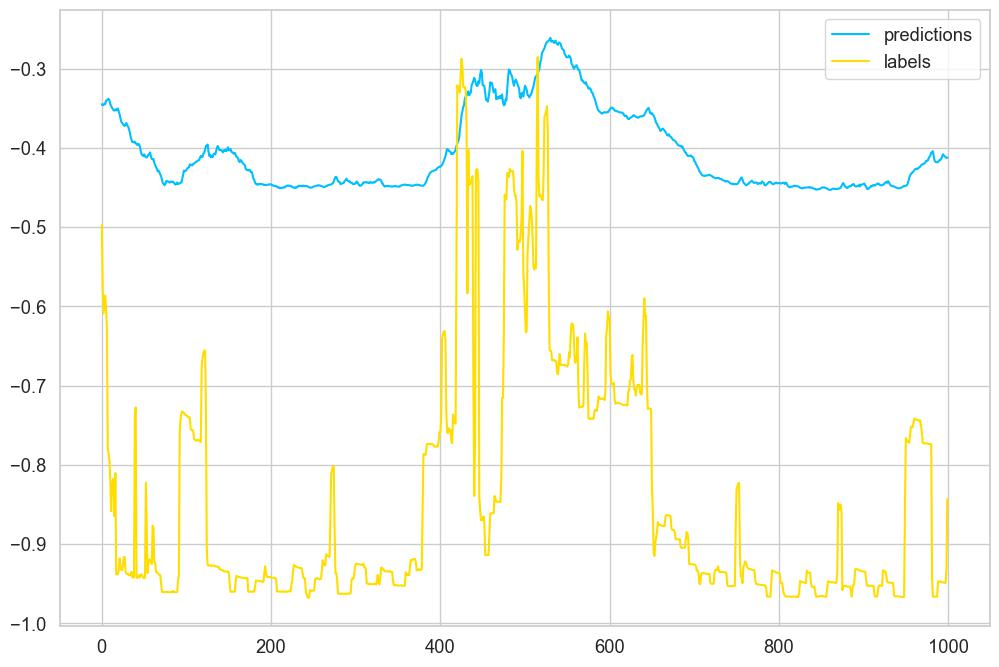

In [101]:
result_test_df[:1000].plot()

In [190]:
preds = []
labels = []
max_steps = 1

step = 0
for item in val_dataset:
    
    if step == max_steps:
        break
    step+=1
    sequence = item['sequence']
    label = item['label']
    
    # print(sequence.unsqueeze(dim=0).size())
    _, pred = model(sequence.unsqueeze(dim=0))
    preds.append(pred.item())
    labels.append(label.item())
    # print(labels, preds)
    # break
preds, labels    

([-0.34471821784973145], [-0.49737462401390076])

In [165]:
import math
# print((pred.item() - label.item())**2)
print(mse(pred.to(torch.device('cpu')), label.to(torch.device('cpu'))))
# label.item()

tensor(0.1857, grad_fn=<SqueezeBackward0>)
